In [4]:
import sys
import os

# Use os.getcwd() since __file__ is not defined
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import torch 
from ultralytics.models import RTDETR

def inspect_rtdetr_output(weights_path, image_path, device):
    rtdetr_model = RTDETR(weights_path).to(device).eval()
    img = torch.randn(1, 3, 640, 640).to(device)

    with torch.no_grad():
        rtdetr_output = rtdetr_model(img)

        print('\n ===== RTDETR OUTPUT ====')
        if isinstance(rtdetr_output, torch.Tensor):
            print('tensor shape:', rtdetr_output.shape)
        elif isinstance(rtdetr_output, dict):
            for k, v in rtdetr_output.items():
                print(f'{k}:{v.shape if isinstance(v, torch.Tensor) else type(v)}')
        else:
            print('output type', type(rtdetr_output))

device='cuda' if torch.cuda.is_available() else 'cpu'
rtdetr_weights_path = '/networkhome/WMGDS/souval_g/Multi-model-RAW-Network/rtdetr-l.pt'

img = torch.rand(1, 3, 640, 640).to(device)

inspect_rtdetr_output(rtdetr_weights_path, img, device)


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.628879547119141. Dividing input by 255.


AttributeError: partially initialized module 'torch._dynamo' has no attribute 'config' (most likely due to a circular import)

In [4]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import torch 
from ultralytics import YOLO
from ultralytics.models import RTDETR

def inspect_yolo_output(weights_path, device):
    yolo_model = YOLO(weights_path).to(device).eval()
    img = torch.rand(1, 3, 640, 640).to(device)  # Use normalized input
    img = torch.clamp(img/255, 0, 1)

    with torch.no_grad():
        yolo_output = yolo_model(img)

        print('\n ===== YOLO OUTPUT ====')
        if isinstance(yolo_output, list):
            print("Output is a list with length:", len(yolo_output))
            result = yolo_output[0]
            print("Result Type:", type(result))

            # Inspect attributes
            print("\n--- Boxes ---")
            print(result.boxes.data if result.boxes else "No detections")
            print("\n--- Scores ---")
            print(result.boxes.conf if result.boxes else "No scores")
            print("\n--- Labels ---")
            print(result.boxes.cls if result.boxes else "No labels")

        else:
            print("Unexpected output type:", type(yolo_output))


# ========== RUN ==========
device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_weights_path = '/networkhome/WMGDS/souval_g/Multi-model-RAW-Network/yolo11x.pt'

inspect_yolo_output(yolo_weights_path, device)



0: 640x640 (no detections), 412.9ms
Speed: 0.0ms preprocess, 412.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

 ===== YOLO OUTPUT ====
Output is a list with length: 1
Result Type: <class 'ultralytics.engine.results.Results'>

--- Boxes ---
No detections

--- Scores ---
No scores

--- Labels ---
No labels



0: 640x640 5 cars, 1 truck, 301.9ms
Speed: 0.0ms preprocess, 301.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

 ===== YOLO OUTPUT (REAL IMAGE) ====

--- Boxes ---
[[     170.52      327.32      256.19      408.24]
 [     72.311      351.87      92.421      373.77]
 [     90.392      350.59      103.39      368.45]
 [     49.228      352.93      61.106      364.89]
 [    0.22768      208.83      56.324       639.2]
 [     61.419      348.81       75.21      368.97]]

--- Scores ---
[    0.92923     0.72412     0.68482     0.46222     0.41187     0.31319]

--- Labels ---
[          2           2           2           2           7           2]


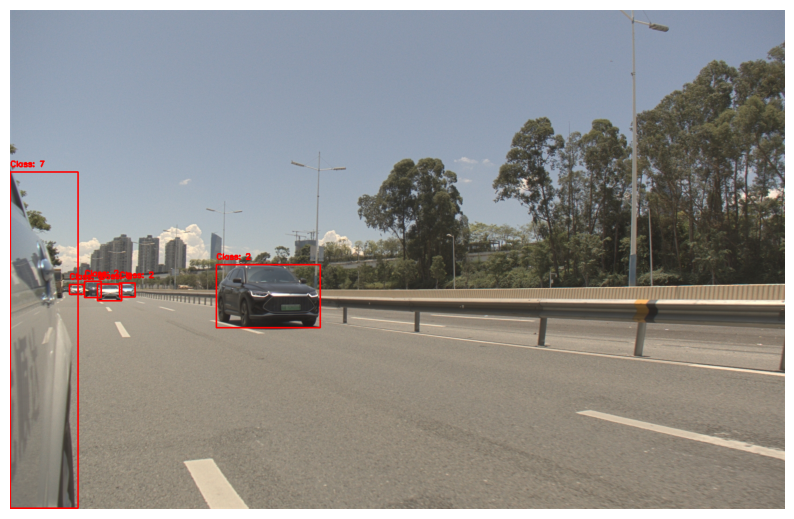

In [10]:
import torch
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np

def load_image(image_path, device):
    """Load an image and normalize it to [0, 1] without resizing for plotting accuracy."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    original_shape = img.shape[:2]              # Store original (height, width)
    resized_img = cv2.resize(img, (640, 640))  # Resize to YOLO input size
    resized_img = resized_img / 255.0           # Normalize to [0, 1]
    resized_img = torch.tensor(resized_img, dtype=torch.float32).permute(2, 0, 1)  # Shape: (C, H, W)
    resized_img = resized_img.unsqueeze(0).to(device)  # Add batch dimension
    return resized_img, img, original_shape


def inspect_yolo_with_real_image(weights_path, image_path, device):
    """Run YOLO inference and return the result."""
    yolo_model = YOLO(weights_path).to(device).eval()
    img_tensor, original_img, original_shape = load_image(image_path, device)

    with torch.no_grad():
        yolo_output = yolo_model(img_tensor)

        print('\n ===== YOLO OUTPUT (REAL IMAGE) ====')
        result = yolo_output[0]

        print("\n--- Boxes ---")
        print(result.boxes.xyxy.cpu().numpy() if result.boxes else "No detections")

        print("\n--- Scores ---")
        print(result.boxes.conf.cpu().numpy() if result.boxes else "No scores")

        print("\n--- Labels ---")
        print(result.boxes.cls.cpu().numpy() if result.boxes else "No labels")

    return result, original_img, original_shape


def plot_image_with_boxes(original_img, result, original_shape):
    """Plot image with YOLO bounding boxes and class labels, scaled to the original size."""
    img = original_img.copy()
    resized_shape = (640, 640)

    if result.boxes:
        # Scale bounding boxes from YOLO size back to original image size
        boxes = result.boxes.xyxy.cpu().numpy()
        scale_w = original_shape[1] / resized_shape[0]
        scale_h = original_shape[0] / resized_shape[1]
        boxes[:, [0, 2]] *= scale_w
        boxes[:, [1, 3]] *= scale_h

        labels = result.boxes.cls.cpu().numpy()

        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = map(int, box)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            img = cv2.putText(img, f'Class: {int(label)}', (x1, y1 - 10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


# ========== RUN ==========
device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_weights_path = '/networkhome/WMGDS/souval_g/Multi-model-RAW-Network/yolo11x.pt'
image_path = '/networkhome/WMGDS/souval_g/Multi-model-RAW-Network/test_images/day-02078.jpg'

result, original_img, original_shape = inspect_yolo_with_real_image(yolo_weights_path, image_path, device)

# Plot image with bounding boxes
plot_image_with_boxes(original_img, result, original_shape)
